In [58]:
import os, zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from pathlib import Path

import ipywidgets
import seaborn as sns
import matplotlib.pyplot as plt

import antropy as ant
from statistics import mode
from scipy.signal import spectrogram, find_peaks
from scipy.stats import skew, kurtosis

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier


In [34]:
def data_ingestion():
    with zipfile.ZipFile(r"D:\Projects\Example\kovai\accelerometer\data\Activity Recognition.zip", 'r') as zip_ref:
        zip_ref.extractall(r'..\data')

    source_data_path = os.path.abspath(r'..\data\Activity Recognition')
    all_data = glob(source_data_path+"/*.csv")

    df = pd.DataFrame()
    for name in all_data:
        df_ = pd.read_csv(name, header=None)
        df_['id'] = int(Path(name).stem)
        df = pd.concat([df, df_.iloc[:,1:]])
    df.columns = ['x', 'y', 'z', 'label', 'id']
    return df


df = data_ingestion()

In [35]:
df.isnull().sum()

x        0
y        0
z        0
label    0
id       0
dtype: int64

In [36]:
activities = {0:"No Activity", 1:"Working at Computer", 2:"Standing Up, Walking and Going up\down stairs", 3:"Standing", 4:"Walking", 5:"Going Up\Down Stairs", 6:"Walking and Talking with Someone", 7:"Talking while Standing"}

In [37]:
per_df = df.groupby(['label']).size() / len(df) * 100
print(per_df)

label
0     0.193005
1    31.587953
2     2.484722
3    11.247986
4    18.530528
5     2.672588
6     2.479117
7    30.804102
dtype: float64


<Axes: title={'center': 'fig 1 - Percentage of Activities recorded'}, xlabel='Activity', ylabel='Percentage'>

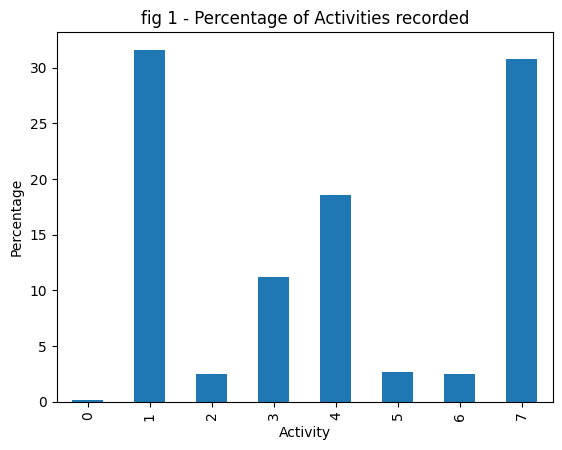

In [38]:
per_df.plot(kind='bar', xlabel='Activity', ylabel='Percentage', title='fig 1 - Percentage of Activities recorded')

label
0      1.191987
1    195.085577
2     15.345513
3     69.466987
4    114.443590
5     16.505769
6     15.310897
7    190.244551
dtype: float64


<Axes: title={'center': 'fig 2 - Time of Activities recorded'}, xlabel='Activity', ylabel='Time in minutes'>

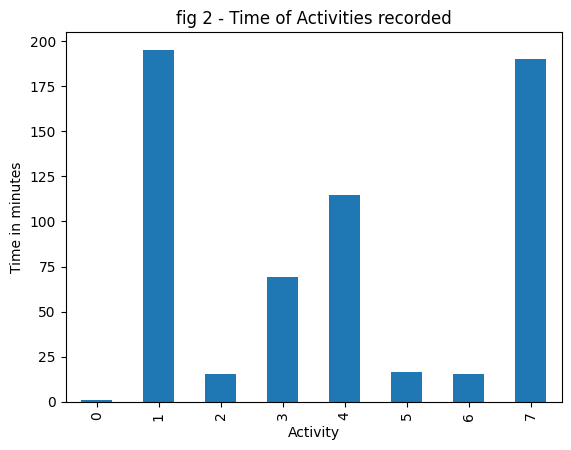

In [39]:
min_df = df.groupby('label').size()/(52 * 60)
print(min_df)


min_df.plot(kind='bar', xlabel='Activity', ylabel='Time in minutes', title='fig 2 - Time of Activities recorded')

In [40]:
def participant_activity_plot_duration(participant_id):
    df_ = df[(df.id==participant_id)]
    min_df = df_.groupby('label').size()/(52 * 60)
    print(min_df)

    min_df.plot(kind='bar', xlabel='Activity', ylabel='Time in minutes', title='Time of Activities recorded')

ipywidgets.interact(participant_activity_plot_duration, participant_id=[i+1 for i in range(15)])

interactive(children=(Dropdown(description='participant_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.participant_activity_plot_duration(participant_id)>

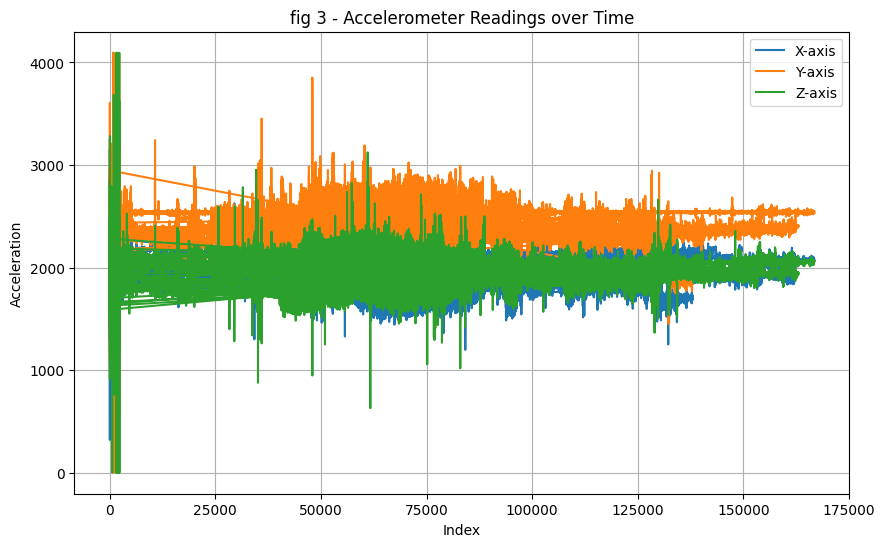

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(df['x'].index, df['x'], label='X-axis')
plt.plot(df['y'].index, df['y'], label='Y-axis')
plt.plot(df['z'].index, df['z'], label='Z-axis')
plt.title('fig 3 - Accelerometer Readings over Time')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
df.head()

,x,y,z,label,id
0,1502,2215,2153,1,1
1,1667,2072,2047,1,1
2,1611,1957,1906,1,1
3,1601,1939,1831,1,1
4,1643,1965,1879,1,1


In [43]:
def plot_participant(participant_id, activity):
    subject = df[(df.id==participant_id) & (df.label==activity)].iloc[:,:3].values
    
    plt.figure()
    for t in range(subject.shape[1]):
        plt.subplot(subject.shape[1], 1, t+1)
        plt.plot(subject[:,t])
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

    
ipywidgets.interact(plot_participant, participant_id=[i+1 for i in range(15)], activity=range(8))

interactive(children=(Dropdown(description='participant_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.plot_participant(participant_id, activity)>

In [44]:
x = df['x']
y = df['y']
z = df['z']

# for _, df_ in :
def amplitude_time_plot(participant_id, activity_id):
    df_ = df[(df['id']==participant_id) & (df['label']==activity_id)]
    time = np.arange(0, len(df_), 1)

    plt.figure(figsize=(10, 6))
    plt.plot(time, df_['x'], label='X Acceleration')
    plt.plot(time, df_['y'], label='Y Acceleration')
    plt.plot(time, df_['z'], label='Z Acceleration')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Participant {participant_id} - Activity: {activities[activity_id]} - Time vs Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

ipywidgets.interact(amplitude_time_plot, participant_id=[i+1 for i in range(15)], activity_id=range(8))

interactive(children=(Dropdown(description='participant_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.amplitude_time_plot(participant_id, activity_id)>

In [45]:
# Compute FFT for each axis
fft_x = np.fft.fft(x)
fft_y = np.fft.fft(y)
fft_z = np.fft.fft(z)

time = np.arange(0, len(df), 1)

# Frequency axis
frequency = np.fft.fftfreq(len(time), d=1)

def frequency_time_plot(participant_id, activity_id):
    try:
        df_ = df[(df['id']==participant_id) & (df['label']==activity_id)]
        fs = 52

        plt.figure(figsize=(10, 6))
        f, t, Sxx = spectrogram(df_['x'], fs=fs, noverlap=int(fs * 0.5))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
        plt.title('Spectrogram of X Acceleration')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.colorbar(label='Power Spectral Density (dB)')
        plt.show()
    except:
        print("No sufficient data")

ipywidgets.interact(frequency_time_plot, participant_id=[i+1 for i in range(15)], activity_id=range(8))

interactive(children=(Dropdown(description='participant_id', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.frequency_time_plot(participant_id, activity_id)>

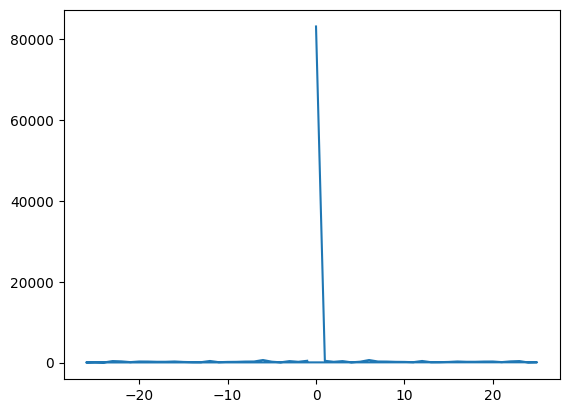

In [46]:
from scipy.fft import fft, fftfreq

SAMPLE_RATE = 52
DURATION = 1

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = fft(df['x'].iloc[:52])
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

In [47]:
def segment_signal(signal, window_length_sec, overlap_ratio=0.5, sampling_rate=52):
    window_length_samples = int(window_length_sec * sampling_rate)
    overlap_length = int(window_length_samples * overlap_ratio)
    stride = window_length_samples - overlap_length
    segments = []
    for i in range(0, len(signal) - window_length_samples + 1, stride):
        segment = signal[i:i + window_length_samples]
        segments.append(segment)
    return segments


window_length_sec = 1
sampling_rate = 52
window_length = window_length_sec * sampling_rate
segments = []
for k, df_ in df.groupby(['id', 'label']):
    sensor_data = df_
    segments.extend(segment_signal(sensor_data, window_length_sec))

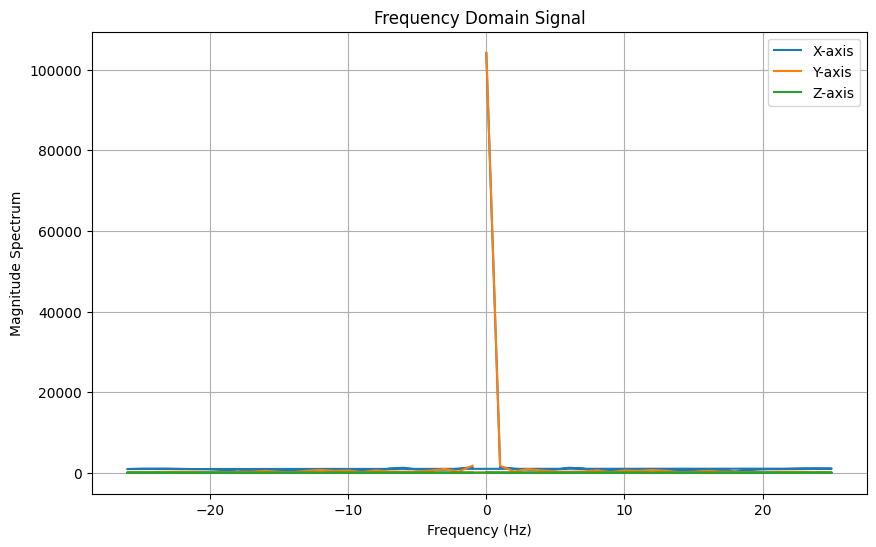

In [48]:
# Apply FFT to each window and compute magnitude spectrum
frequency_bins = np.fft.fftfreq(window_length, 1 / sampling_rate)
frequency_domain_signals = []
for segment in segments:
    fft_results = np.fft.fft(segment, axis=0)
    magnitude_spectrum = np.abs(fft_results)
    frequency_domain_signals.append(magnitude_spectrum)

# Plot the frequency domain signal for a sample window
sample_window_index = 0
plt.figure(figsize=(10, 6))
plt.plot(frequency_bins, frequency_domain_signals[sample_window_index][:, 1], label='X-axis')
plt.plot(frequency_bins, frequency_domain_signals[sample_window_index][:, 2], label='Y-axis')
plt.plot(frequency_bins, frequency_domain_signals[sample_window_index][:, 3], label='Z-axis')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude Spectrum')
plt.title('Frequency Domain Signal')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
frame_size = 52

def get_mean_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    current_mean = np.sum(y)/frame_size
    return current_mean

def get_variance_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    current_var = (np.sum((y - (np.sum(y)/frame_size))**2))/(frame_size-1)
    return current_var

def get_third_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    current_third = (np.sum((y - (np.sum(y)/frame_size))**3))/(frame_size * (np.sqrt((np.sum((y - (np.sum(y)/frame_size))**2))/(frame_size-1)))**3)
    return current_third

def get_forth_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    current_forth = (np.sum((y - (np.sum(y)/frame_size))**4))/(frame_size * ((np.sum((y - (np.sum(y)/frame_size))**2))/(frame_size-1))**2)

    return current_forth

def get_grand_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L, 1/frame_size)[:int(L/2)] 
    current_grand = np.sum(f * y)/np.sum(y)
    return current_grand

def get_std_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L, 1/frame_size)[:int(L/2)] 
    current_std = np.sqrt(np.sum((f-(np.sum(f * y)/np.sum(y)))**2 * y)/frame_size)
    return current_std

def get_Cfactor_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L, 1/frame_size)[:int(L/2)] 
    current_cfactor = np.sqrt(np.sum(f**2 * y)/np.sum(y))
    return current_cfactor

def get_Dfactor_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L, 1/frame_size)[:int(L/2)] 
    current_dfactor = np.sqrt(np.sum(f**4 * y)/np.sum(f**2 * y))
    return current_dfactor

def get_Efactor_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L, 1/frame_size)[:int(L/2)] 
    current_efactor = np.sqrt(np.sum(f**2 * y)/np.sqrt(np.sum(y) * np.sum(f**4 * y)))
    return current_efactor

def get_Gfactor_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L, 1/frame_size)[:int(L/2)] 
    current_gfactor = (np.sqrt(np.sum((f-(np.sum(f * y)/np.sum(y)))**2 * y)/frame_size))/(np.sum(f * y)/np.sum(y))
    return current_gfactor

def get_third1_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L, 1/frame_size)[:int(L/2)] 
    current_third1 = np.sum((f - (np.sum(f * y)/np.sum(y)))**3 * y)/(frame_size * (np.sqrt(np.sum((f-(np.sum(f * y)/np.sum(y)))**2 * y)/frame_size))**3)
    return current_third1

def get_forth1_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L, 1/frame_size)[:int(L/2)] 
    current_forth1 = np.sum((f - (np.sum(f * y)/np.sum(y)))**4 * y)/(frame_size * (np.sqrt(np.sum((f-(np.sum(f * y)/np.sum(y)))**2 * y)/frame_size))**4)
    return current_forth1

def get_Hfactor_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L, 1/frame_size)[:int(L/2)] 
    current_hfactor = np.sum(np.sqrt(abs(f - (np.sum(f * y)/np.sum(y)))) * y)/(frame_size * np.sqrt(np.sqrt(np.sum((f-(np.sum(f * y)/np.sum(y)))**2 * y)/frame_size)))
    return current_hfactor

def get_Jfactor_freq(signal):
    L = len(signal)
    y = abs(np.fft.fft(signal/L))[:int(L/2)]
    f = np.fft.fftfreq (L,  1/frame_size)[:int(L/2)] 
    current_jfactor = np.sum(np.sqrt(abs(f - (np.sum(f * y)/np.sum(y)))) * y)/(frame_size * np.sqrt(np.sqrt(np.sum((f-(np.sum(f * y)/np.sum(y)))**2 * y)/frame_size)))
    return current_jfactor

In [50]:
list_features_function = [get_mean_freq, get_variance_freq, get_third_freq, get_forth_freq, get_grand_freq,
                         get_std_freq, get_Cfactor_freq, get_Dfactor_freq, get_Efactor_freq, get_Gfactor_freq,
                         get_third1_freq, get_forth1_freq, get_Hfactor_freq, get_Jfactor_freq]

print('Number of feature extruction methods: ', len(list_features_function))

Number of feature extruction methods:  14


In [57]:
def get_all_fetures(X):
    stationary_features = [func(X) for func in list_features_function]
    return stationary_features

d:\Projects\Example\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


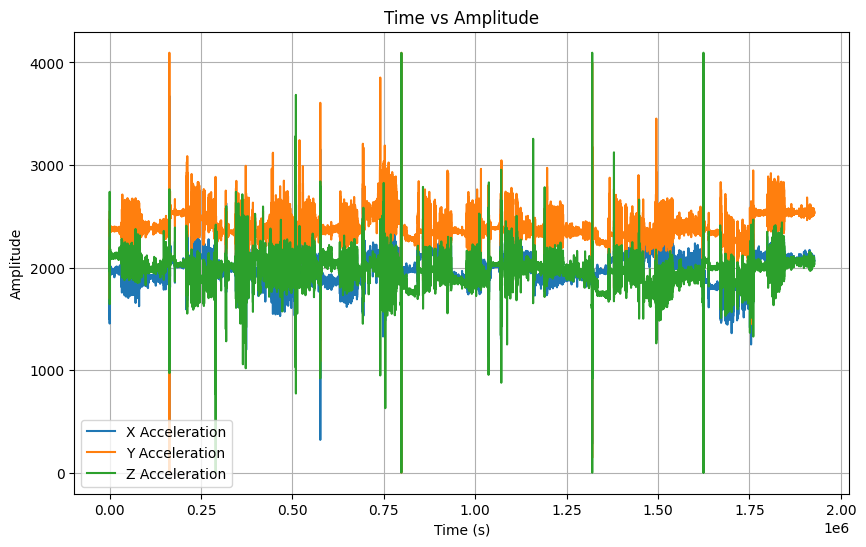

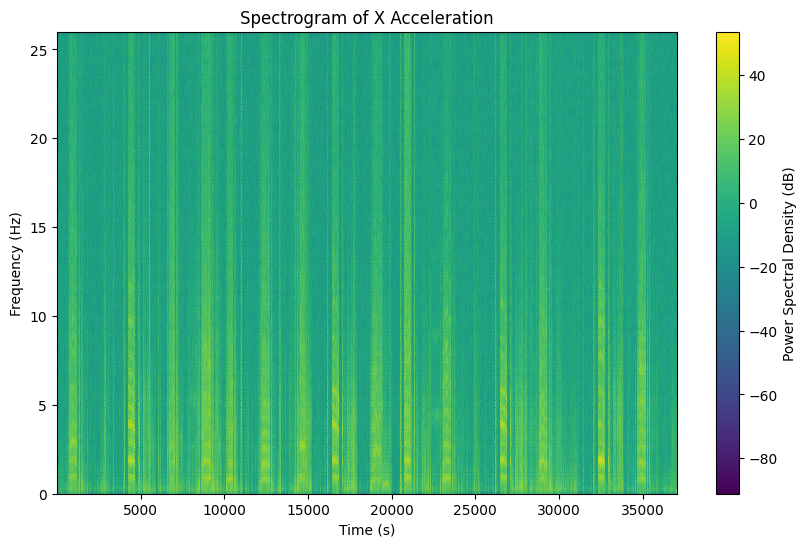

In [53]:
time = np.arange(0, len(df), 1)
x = df['x']
y = df['y']
z = df['z']

# Time vs Amplitude plot
plt.figure(figsize=(10, 6))
plt.plot(time, df['x'], label='X Acceleration')
plt.plot(time, df['y'], label='Y Acceleration')
plt.plot(time, df['z'], label='Z Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time vs Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Compute FFT for each axis
fft_x = np.fft.fft(x)
fft_y = np.fft.fft(y)
fft_z = np.fft.fft(z)

# Frequency axis
frequency = np.fft.fftfreq(len(time), d=1)

# Frequency vs Time plot
fs = 52
plt.figure(figsize=(10, 6))
f, t, Sxx = spectrogram(df['x'], fs=fs, noverlap=int(fs * 0.5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram of X Acceleration')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.colorbar(label='Power Spectral Density (dB)')
plt.show()

In [60]:
def extract_features(segment_data):
    features = [np.mean(segment_data[['x','y','z']].apply(lambda df_: np.sqrt(df_.x**2 + df_.y**2 + df_.z**2), axis=1))]
    features.append(np.mean(np.correlate(segment_data['x'], segment_data['y'], mode='full')))
    features.append(np.mean(np.correlate(segment_data['x'], segment_data['z'], mode='full')))
    features.append(np.mean(np.correlate(segment_data['z'], segment_data['y'], mode='full')))
    mag_arr = np.sqrt(segment_data['x']**2 + segment_data['y']**2 + segment_data['z']**2)
    zero_cross = ant.num_zerocross(mag_arr)
    features.append(zero_cross)

    label = mode(segment_data['label'])

    for col in ['x', 'y', 'z']:
        segment = segment_data[col]
        features.append(np.mean(segment))
        features.append(np.var(segment))
        features.append(np.std(segment))
        features.append(np.std(segment) / np.mean(segment)) # Coefficient of variation
        features.append(skew(segment))
        features.append(kurtosis(segment))
        features.append(np.percentile(segment, 10))
        features.append(np.percentile(segment, 25))
        features.append(np.percentile(segment, 50))
        features.append(np.percentile(segment, 75))
        features.append(np.percentile(segment, 90))
        features.append(np.percentile(segment, 75) - np.percentile(segment, 25))
        features.append(np.min(segment))
        features.append(np.max(segment))
        arr_sqrd = np.power(mag_arr, 2)
        
        signal_power = np.sum(np.abs(arr_sqrd)) / len(mag_arr)
        log_energy = np.sum(np.log(arr_sqrd))
        features.append(signal_power)
        features.append(log_energy)

        peak_intensity = len(find_peaks(segment)[0])
        features.append(peak_intensity)

        fft_results = np.fft.fft(segment, axis=0)
        Sxx = np.abs(fft_results)**2

        mean_power = np.mean(Sxx)
        max_power = np.max(Sxx)
        min_power = np.min(Sxx)

        features.append(mean_power)
        features.append(max_power)
        features.append(min_power)

        features.extend(get_all_fetures(fft_results))
        
    return features, label, segment_data.index


train_data = [extract_features(segment) for segment in tqdm(segments, total=len(segments))]

X = pd.DataFrame([i for i, j, idx in train_data])
y = pd.Series([j for i, j, idx in train_data])
indices = pd.Series([idx for i, j, idx in train_data])

100%|██████████| 73953/73953 [41:21<00:00, 29.80it/s] 


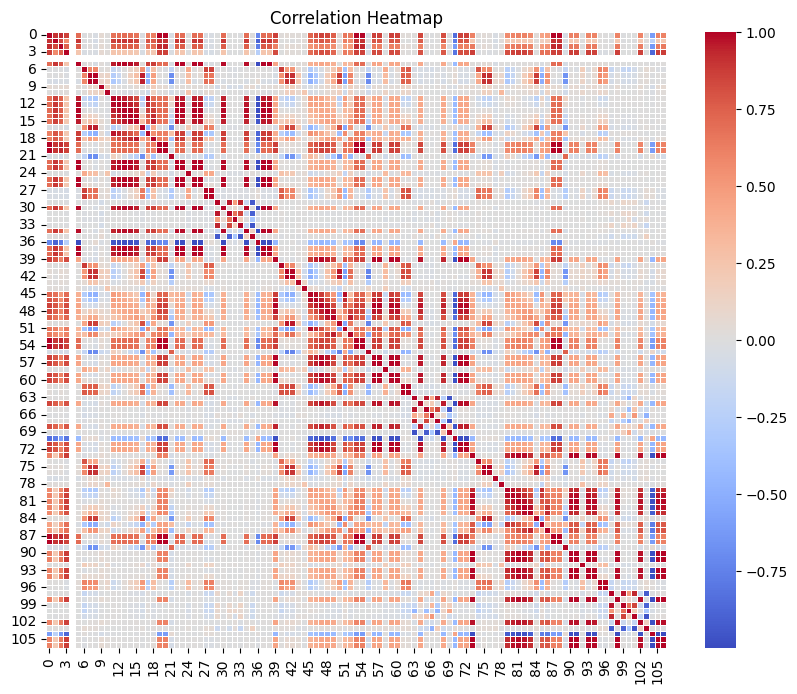

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

[0.8809411128388885, 0.886958285443851, 0.8827665472246636, 0.8826910074374578, 0.8841108857336037]
Average accuracy: 0.883493567735693
              precision    recall  f1-score   support

           0       0.73      0.32      0.44        25
           1       0.95      0.96      0.96      4752
           2       0.83      0.43      0.57       367
           3       0.78      0.68      0.73      1649
           4       0.84      0.95      0.89      2696
           5       0.76      0.48      0.59       404
           6       0.78      0.37      0.51       342
           7       0.88      0.95      0.92      4555

    accuracy                           0.88     14790
   macro avg       0.82      0.64      0.70     14790
weighted avg       0.88      0.88      0.88     14790



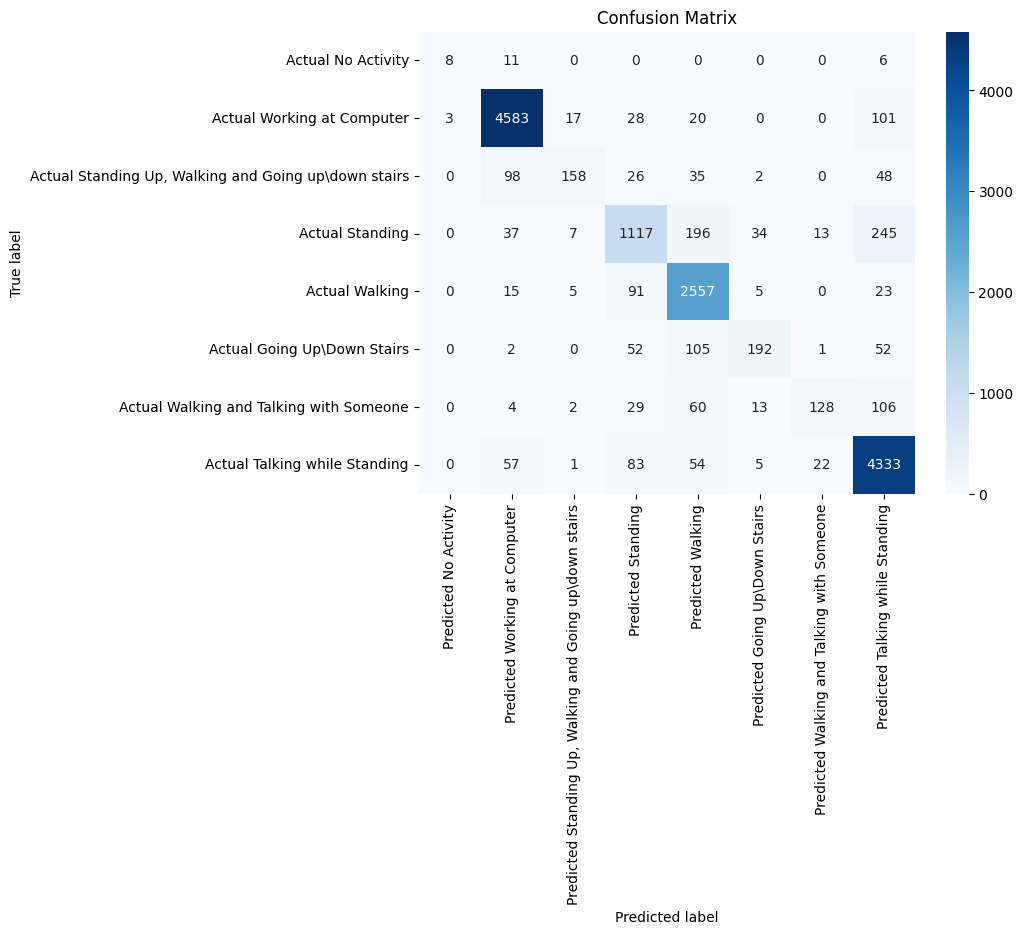

In [62]:
def model_creation(X, y, num_folds=5):
    accuracy_scores = []
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        best_accuracy = 0
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        indices_train, indices_test = indices[train_index], indices[test_index]
        
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    average_accuracy = np.mean(accuracy_scores)
    print(accuracy_scores)
    print("Average accuracy:", average_accuracy)

    return best_model, X_train, X_test, y_train, y_test, indices_train, indices_test


def model_classification_report(y_test, y_pred):
    # Calculate & Print Classification Report
    print(classification_report(y_test, y_pred))


def model_confusion_matrix(y_test, y_pred):
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[f'Predicted {activities[i]}' for i in set(y)], 
                yticklabels=[f'Actual {activities[i]}' for i in set(y)])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()



model, X_train, X_test, y_train, y_test, indices_train, indices_test = model_creation(X, y)
model_classification_report(y_test, model.predict(X_test))
model_confusion_matrix(y_test, model.predict(X_test))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_jobs=-1)

# Initialize GridSearchCV with Random Forest classifier and parameter grid
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search on training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

# Make predictions on the testing data using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


In [64]:
print("Predicted Label: ", y_test.iloc[1000])
df.iloc[indices_test.iloc[1000]]

Predicted Label:  7


,x,y,z,label,id
127762,1906,2388,2004,7,1
127763,1899,2387,1995,7,1
127764,1901,2380,1998,7,1
127765,1899,2381,2002,7,1
127766,1903,2385,1993,7,1
127767,1899,2383,1995,7,1
127768,1899,2386,1997,7,1
127769,1903,2382,1999,7,1
127770,1902,2382,1998,7,1
127771,1905,2383,2002,7,1


In [65]:
df_without_none = df[~(df['label'].isin([0]))]
df_without_none.head()

,x,y,z,label,id
0,1502,2215,2153,1,1
1,1667,2072,2047,1,1
2,1611,1957,1906,1,1
3,1601,1939,1831,1,1
4,1643,1965,1879,1,1


In [66]:
segments_without_none = []
for k, df_ in df_without_none.groupby(['id', 'label']):
    sensor_data = df_
    window_length_sec = 1
    sampling_rate = 52
    segments_without_none.extend(segment_signal(sensor_data, window_length_sec))


train_data_without_none = [extract_features(segment) for segment in tqdm(segments_without_none, total=len(segments_without_none))]

X1 = pd.DataFrame([i for i, j, idx in train_data_without_none])
y1 = pd.Series([j for i, j, idx in train_data_without_none])
indices1 = pd.Series([idx for i, j, idx in train_data_without_none])

100%|██████████| 73817/73817 [08:22<00:00, 146.77it/s]


[0.8813329720942834, 0.8882416689244107, 0.8855923592765698, 0.8842376210797264, 0.8832215674320938]
Average accuracy: 0.8845252377614168
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      0.99      0.99      4746
           2       0.98      0.87      0.92       343
           3       0.95      0.91      0.93      1660
           4       0.96      0.99      0.97      2690
           5       0.97      0.87      0.92       406
           6       0.97      0.83      0.89       363
           7       0.97      0.98      0.98      4555

    accuracy                           0.97     14763
   macro avg       0.85      0.81      0.83     14763
weighted avg       0.97      0.97      0.97     14763



d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


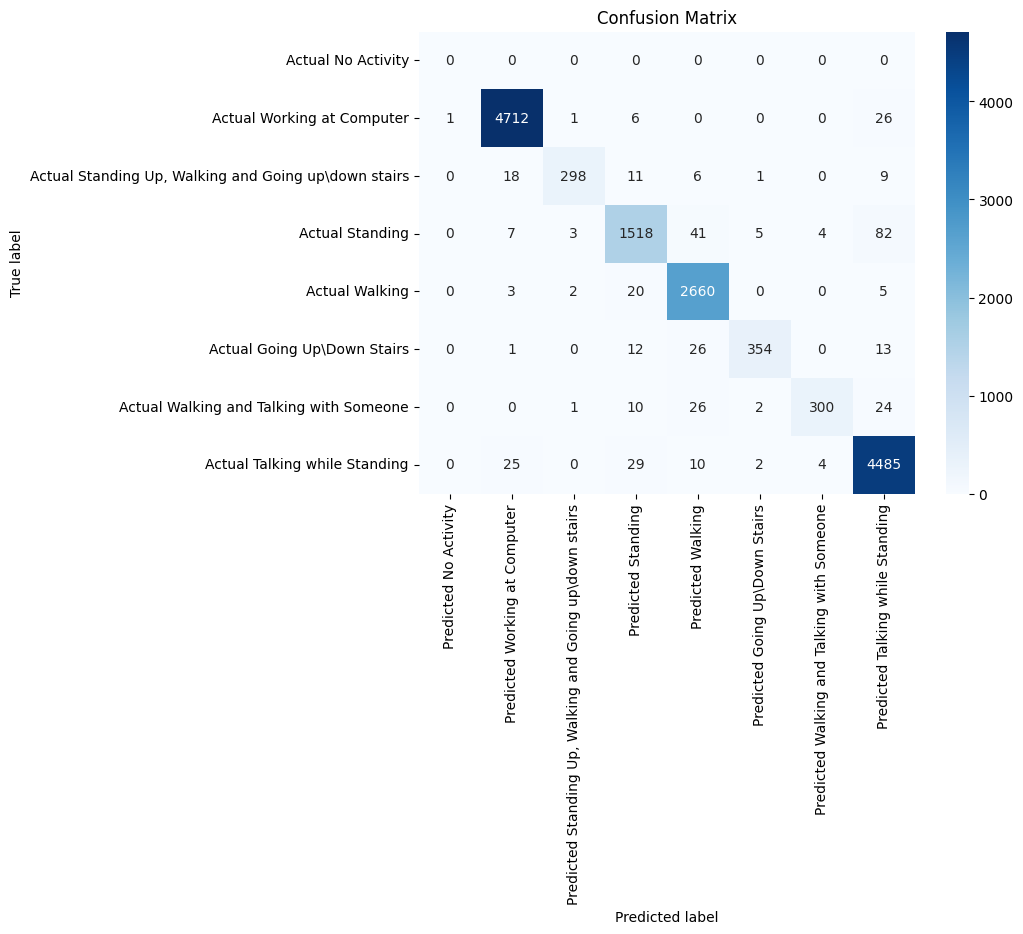

In [67]:
model1, X_train1, X_test1, y_train1, y_test1, indices_train1, indices_test1 = model_creation(X1, y1)
model_classification_report(y_test1, model.predict(X_test1))
model_confusion_matrix(y_test1, model.predict(X_test1))

In [49]:
print("Predicted Label: ", y_test1.iloc[500])
df.iloc[indices_test1.iloc[500]]

Predicted Label:  4


,x,y,z,label,id,xf,yf,zf
55128,1926,2367,2008,4,1,-14350.890265,159002.024256,49158.076731
55129,1935,2414,2032,4,1,-20072.582223,62272.908474,-42851.396349
55130,1944,2466,2018,4,1,-4278.806946,-12236.033507,9288.902875
55131,1935,2509,2026,4,1,3959.223857,-27031.534839,78684.647271
55132,1906,2542,2023,4,1,-65596.105068,108178.884173,-40561.096339
55133,1905,2522,1978,4,1,26507.340283,-45535.100714,82086.597998
55134,1914,2561,2159,4,1,30633.565787,24412.192640,-52064.366102
55135,1939,2588,2183,4,1,7588.540814,-14065.332833,-65297.690984
55136,1923,2565,2145,4,1,-11659.835902,-104894.368141,4185.743879
55137,1816,2455,2165,4,1,-31380.051323,116099.443677,20737.138313


In [68]:
df_without_stairs = df[~(df['label'].isin([0,2,6]))]

segments_without_stairs = []
for k, df_ in df_without_stairs.groupby(['id', 'label']):
    sensor_data = df_
    window_length_sec = 1
    sampling_rate = 52
    segments_without_stairs.extend(segment_signal(sensor_data, window_length_sec))

train_data_without_stairs = [extract_features(segment) for segment in tqdm(segments_without_stairs, total=len(segments_without_stairs))]

100%|██████████| 70181/70181 [07:57<00:00, 146.82it/s]


In [69]:
X2 = pd.DataFrame([i for i, j, idx in train_data_without_stairs])
y2 = pd.Series([j for i, j, idx in train_data_without_stairs])
indices2 = pd.Series([idx for i, j, idx in train_data_without_stairs])


[0.9090973854812282, 0.9098033627814192, 0.9110857794243374, 0.9117269877457965, 0.9094471359361641]
Average accuracy: 0.9102321302737891
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      0.99      4657
           2       0.00      0.00      0.00         0
           3       0.96      0.94      0.95      1658
           4       0.98      0.99      0.98      2771
           5       0.97      0.90      0.93       387
           6       0.00      0.00      0.00         0
           7       0.98      0.99      0.99      4563

    accuracy                           0.98     14036
   macro avg       0.61      0.60      0.61     14036
weighted avg       0.98      0.98      0.98     14036



d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


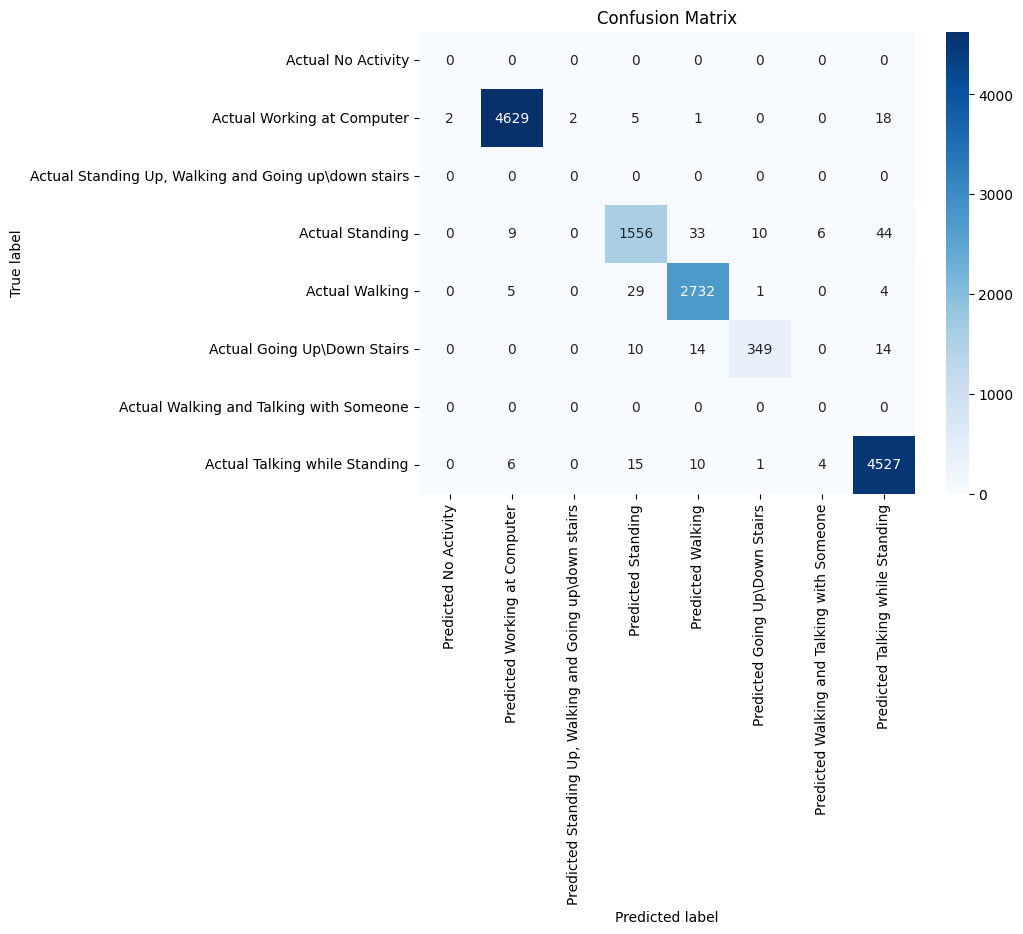

In [70]:
model2, X_train2, X_test2, y_train2, y_test2, indices_train2, indices_test2 = model_creation(X2, y2)
model_classification_report(y_test2, model.predict(X_test2))
model_confusion_matrix(y_test2, model.predict(X_test2))

In [54]:
print("Predicted Label: ", y_test2.iloc[500])
df.iloc[indices_test2.iloc[500]]

Predicted Label:  4


,x,y,z,label,id,xf,yf,zf
54426,1957,2244,2018,4,1,-28971.143648,60125.348851,-64537.552831
54427,1946,2243,2026,4,1,-38447.461546,16451.747838,-58769.216634
54428,1915,2251,2046,4,1,-20419.638145,38796.844251,10050.247109
54429,1900,2256,2031,4,1,66018.102138,-135700.938054,-22819.684729
54430,1882,2284,2037,4,1,12149.592598,26693.997301,30083.934891
54431,1872,2319,2038,4,1,-237.276186,150670.869667,-12596.495712
54432,1870,2364,2038,4,1,34444.471506,-135532.734882,22802.363821
54433,1858,2430,2016,4,1,-2808.884967,92508.531469,93025.185372
54434,1843,2489,1998,4,1,-20153.776999,89717.638737,-8028.518484
54435,1794,2530,1973,4,1,-33468.972201,-127931.271621,-52942.278229


       x     y     z  label  id
84  1670  2147  2079      1   1
88  1726  2203  2005      1   1
89  1778  2143  1946      1   1
90  1718  2102  2012      1   1
93  1664  2241  2064      1   1


100%|██████████| 69190/69190 [07:51<00:00, 146.63it/s]


[0.907428819193525, 0.9166787107963579, 0.9093799682034976, 0.9117647058823529, 0.914004914004914]
Average accuracy: 0.9118514236161295
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      0.98      0.98      4598
           2       0.00      0.00      0.00         0
           3       0.92      0.78      0.84      1661
           4       0.91      0.97      0.94      2654
           5       0.93      0.73      0.82       400
           6       0.00      0.00      0.00         0
           7       0.94      0.98      0.96      4525

    accuracy                           0.95     13838
   macro avg       0.59      0.56      0.57     13838
weighted avg       0.95      0.95      0.95     13838



d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\Example\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


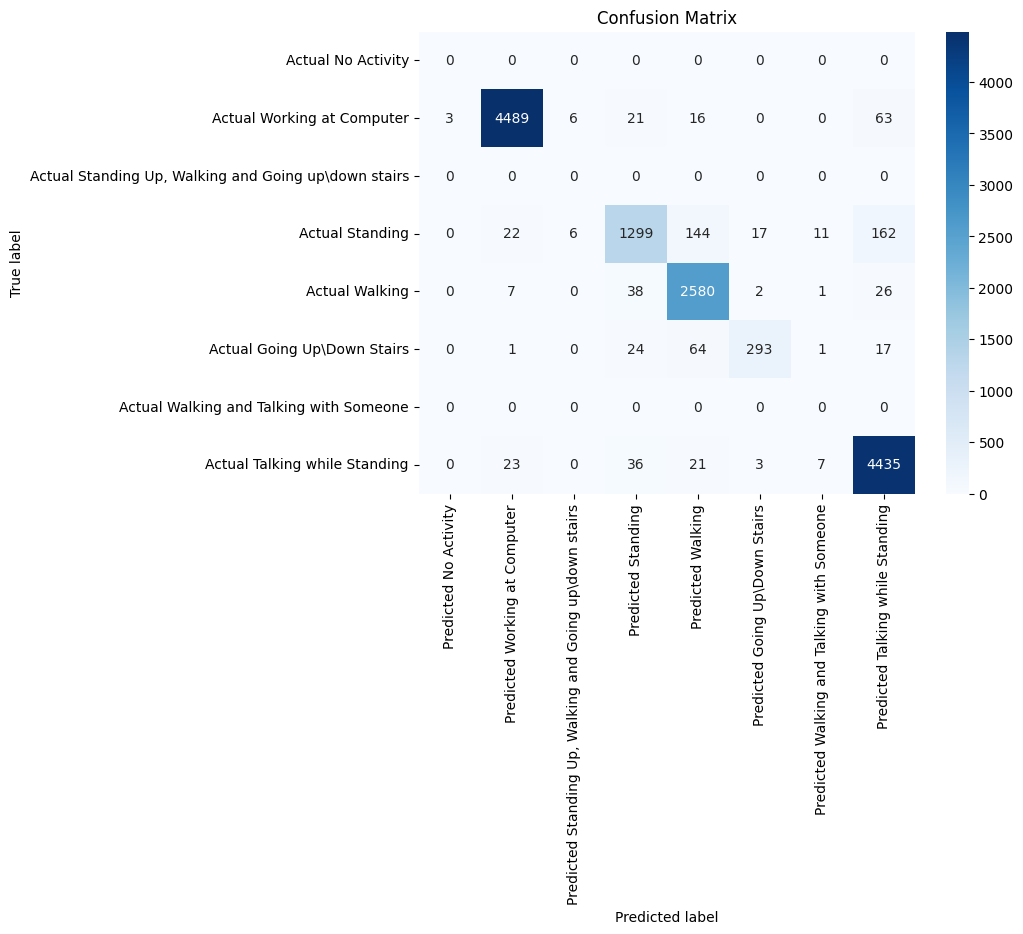

In [71]:
def remove_outliers_zscore(df, threshold=3):
    z_scores = df.apply(lambda x: np.abs((x - x.mean()) / x.std()))
    return df[(z_scores < threshold).all(axis=1)]

df_without_stairs_outliers = remove_outliers_zscore(df[~(df['label'].isin([0,2,6]))])
print(df_without_stairs_outliers.head())

segments_without_stairs_outliers = []
for k, df_ in df_without_stairs_outliers.groupby(['id', 'label']):
    sensor_data = df_
    window_length_sec = 1
    sampling_rate = 52
    segments_without_stairs_outliers.extend(segment_signal(sensor_data, window_length_sec))


train_data_without_stairs_outliers = [extract_features(segment) for segment in tqdm(segments_without_stairs_outliers, total=len(segments_without_stairs_outliers))]

X3 = pd.DataFrame([i for i, j, idx in train_data_without_stairs_outliers])
y3 = pd.Series([j for i, j, idx in train_data_without_stairs_outliers])
indices3 = pd.Series([idx for i, j, idx in train_data_without_stairs_outliers])

model3, X_train3, X_test3, y_train3, y_test3, indices_train3, indices_test3 = model_creation(X3, y3)
model_classification_report(y_test3, model.predict(X_test3))
model_confusion_matrix(y_test3, model.predict(X_test3))

In [57]:
import joblib


def save_model(model, output_path):
    os.makedirs(output_path, exist_ok=True)
    joblib.dump(model, os.path.join(output_path, "model.pkl"))


def load_model(model_path):
    try:
        joblib.load(os.path.join(model_path, "model.pkl"))
    except:
        print("Unable to load model")

In [60]:
save_model(model, r"..\artifacts\model_all_data")
save_model(model1, r"..\artifacts\model_without_none")
save_model(model2, r"..\artifacts\model_without_026")
save_model(model3, r"..\artifacts\model_handled_outliers_removed_026")

In [85]:
# n_components = 20
# pca = PCA(n_components=n_components)

# pca.fit(X3)
# X3_pca = pca.transform(X3)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


# model_creation(pd.DataFrame(X3_pca), y3)
# model = model_creation(pd.DataFrame(scaler.fit_transform(X3), columns=X3.columns), y3)


y3.value_counts()


# # Plot confusion matrix
# y_pred_1 = model.predict(pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns))
# cm = confusion_matrix(y_test, y_pred_1, labels=[0, 1,3,4,5,7])
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted 0', 'Predicted 1'], 
#             yticklabels=['Actual 0', 'Actual 1'])
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.title('Confusion Matrix')
# plt.show()
# cm

1    23084
7    22538
4    13394
3     8241
5     1932
Name: count, dtype: int64